In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

## Prepare

In [2]:
# arguments
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cuda


In [3]:
# construct dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

### Check Images

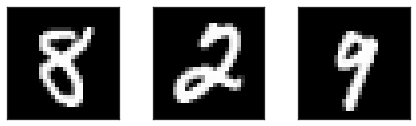

In [4]:
import matplotlib.pyplot as plt
 
_, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

## Training

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

### Models

In [6]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 
    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

### Train Teacher Model

==========> Not find checkpoint, train
00:06:20 --- Epoch: 0	Train loss: 0.4581	Valid loss: 0.1415	Train accuracy: 95.31	Valid accuracy: 95.86
00:06:44 --- Epoch: 1	Train loss: 0.1227	Valid loss: 0.0820	Train accuracy: 97.20	Valid accuracy: 97.21
00:07:08 --- Epoch: 2	Train loss: 0.0856	Valid loss: 0.0703	Train accuracy: 97.77	Valid accuracy: 97.60
00:07:32 --- Epoch: 3	Train loss: 0.0676	Valid loss: 0.0481	Train accuracy: 98.38	Valid accuracy: 98.40
00:07:57 --- Epoch: 4	Train loss: 0.0562	Valid loss: 0.0479	Train accuracy: 98.45	Valid accuracy: 98.48
00:08:21 --- Epoch: 5	Train loss: 0.0482	Valid loss: 0.0484	Train accuracy: 98.62	Valid accuracy: 98.45
00:08:45 --- Epoch: 6	Train loss: 0.0416	Valid loss: 0.0389	Train accuracy: 99.06	Valid accuracy: 98.80
00:09:09 --- Epoch: 7	Train loss: 0.0360	Valid loss: 0.0387	Train accuracy: 99.10	Valid accuracy: 98.71
00:09:34 --- Epoch: 8	Train loss: 0.0330	Valid loss: 0.0351	Train accuracy: 99.18	Valid accuracy: 98.86
00:09:58 --- Epoch: 9	Tra

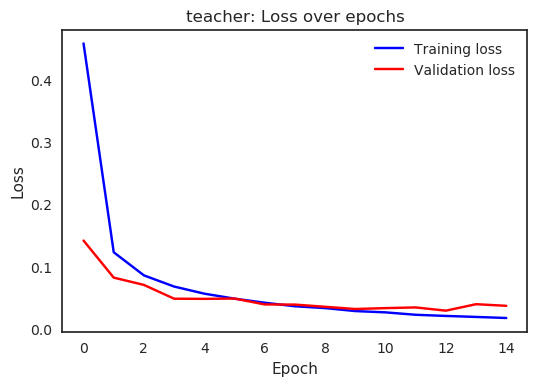

In [7]:
LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"
torch.manual_seed(RANDOM_SEED)

model_teacher = LeNet5(N_CLASSES).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):
    # load model Directly
    print("==========> Load Parameters")
    model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))

else:
    # If model not trained 
    print("==========> Not find checkpoint, train")

    LEARNING_RATE = 0.001
    N_EPOCHS = 15
    optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
    train_criterion = nn.CrossEntropyLoss()
    valid_criterion = nn.CrossEntropyLoss()
    params = {"dir":'.',
              "prefix": "teacher",
              "title": "teacher"
             }
    
    model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                                train_loader, test_loader, N_EPOCHS, DEVICE, params)

    # Save model 
    torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)

### Train Student Model
Q2

#### Train student model base on groud Truth

=======> Student trained on Ground Truth
00:12:20 --- Epoch: 0	Train loss: 1.0444	Valid loss: 0.5335	Train accuracy: 83.46	Valid accuracy: 84.50
00:12:41 --- Epoch: 1	Train loss: 0.5165	Valid loss: 0.4464	Train accuracy: 85.90	Valid accuracy: 86.93
00:13:01 --- Epoch: 2	Train loss: 0.4539	Valid loss: 0.4055	Train accuracy: 87.33	Valid accuracy: 88.13
00:13:22 --- Epoch: 3	Train loss: 0.4188	Valid loss: 0.3781	Train accuracy: 88.25	Valid accuracy: 89.03
00:13:43 --- Epoch: 4	Train loss: 0.3975	Valid loss: 0.3652	Train accuracy: 88.61	Valid accuracy: 89.36
00:14:04 --- Epoch: 5	Train loss: 0.3824	Valid loss: 0.3555	Train accuracy: 88.95	Valid accuracy: 89.85
00:14:25 --- Epoch: 6	Train loss: 0.3719	Valid loss: 0.3491	Train accuracy: 88.95	Valid accuracy: 89.70
00:14:47 --- Epoch: 7	Train loss: 0.3627	Valid loss: 0.3409	Train accuracy: 89.43	Valid accuracy: 90.14
00:15:09 --- Epoch: 8	Train loss: 0.3549	Valid loss: 0.3358	Train accuracy: 89.56	Valid accuracy: 90.35
00:15:30 --- Epoch: 9	T

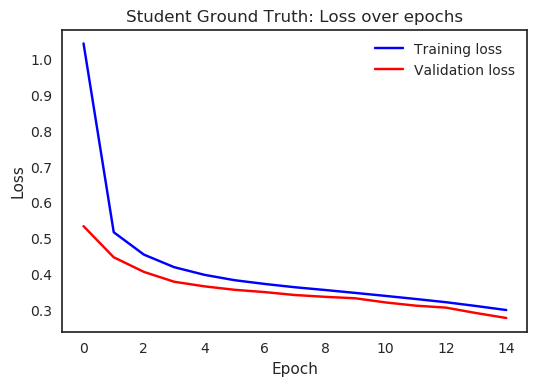

In [8]:
LEARNING_RATE = 0.001
N_EPOCHS = 15

print(f"=======> Student trained on Ground Truth")
model_s = StudentNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

#### Train student model base on teacher's soft label
Q2, Q3

Small Model : *Student Model*

Different Temprature

=======> Temperature: 1
00:17:37 --- Epoch: 0	Train loss: 1.2620	Valid loss: 0.4325	Train accuracy: 85.95	Valid accuracy: 87.31
00:18:02 --- Epoch: 1	Train loss: 0.3851	Valid loss: 0.3250	Train accuracy: 88.84	Valid accuracy: 89.96
00:18:25 --- Epoch: 2	Train loss: 0.3263	Valid loss: 0.2929	Train accuracy: 89.99	Valid accuracy: 90.93
00:18:48 --- Epoch: 3	Train loss: 0.3006	Valid loss: 0.2767	Train accuracy: 90.65	Valid accuracy: 91.40
00:19:12 --- Epoch: 4	Train loss: 0.2832	Valid loss: 0.2664	Train accuracy: 91.05	Valid accuracy: 91.83
00:19:35 --- Epoch: 5	Train loss: 0.2711	Valid loss: 0.2579	Train accuracy: 91.37	Valid accuracy: 92.08
00:19:58 --- Epoch: 6	Train loss: 0.2615	Valid loss: 0.2518	Train accuracy: 91.54	Valid accuracy: 92.14
00:20:23 --- Epoch: 7	Train loss: 0.2544	Valid loss: 0.2427	Train accuracy: 91.73	Valid accuracy: 92.42
00:20:49 --- Epoch: 8	Train loss: 0.2473	Valid loss: 0.2382	Train accuracy: 92.05	Valid accuracy: 92.63
00:21:12 --- Epoch: 9	Train loss: 0.2420

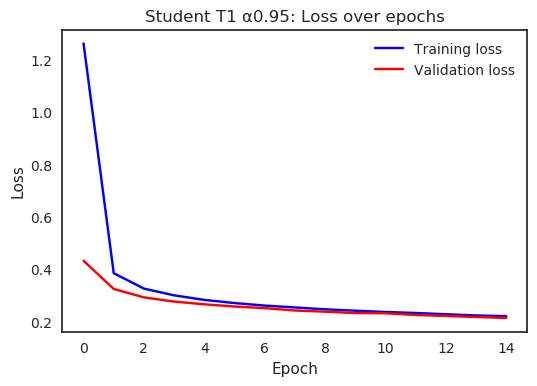

=======> Temperature: 1.5
00:23:34 --- Epoch: 0	Train loss: 2.4873	Valid loss: 0.4960	Train accuracy: 85.26	Valid accuracy: 86.02
00:23:56 --- Epoch: 1	Train loss: 0.9137	Valid loss: 0.4169	Train accuracy: 88.29	Valid accuracy: 88.58
00:24:21 --- Epoch: 2	Train loss: 0.7728	Valid loss: 0.3759	Train accuracy: 89.46	Valid accuracy: 89.62
00:24:47 --- Epoch: 3	Train loss: 0.6958	Valid loss: 0.3530	Train accuracy: 90.24	Valid accuracy: 90.22
00:25:11 --- Epoch: 4	Train loss: 0.6442	Valid loss: 0.3239	Train accuracy: 91.04	Valid accuracy: 91.05
00:25:36 --- Epoch: 5	Train loss: 0.6061	Valid loss: 0.3114	Train accuracy: 91.50	Valid accuracy: 91.47
00:25:59 --- Epoch: 6	Train loss: 0.5769	Valid loss: 0.3043	Train accuracy: 91.72	Valid accuracy: 91.73
00:26:23 --- Epoch: 7	Train loss: 0.5535	Valid loss: 0.2943	Train accuracy: 92.12	Valid accuracy: 92.02
00:26:47 --- Epoch: 8	Train loss: 0.5324	Valid loss: 0.2819	Train accuracy: 92.42	Valid accuracy: 92.55
00:27:10 --- Epoch: 9	Train loss: 0.51

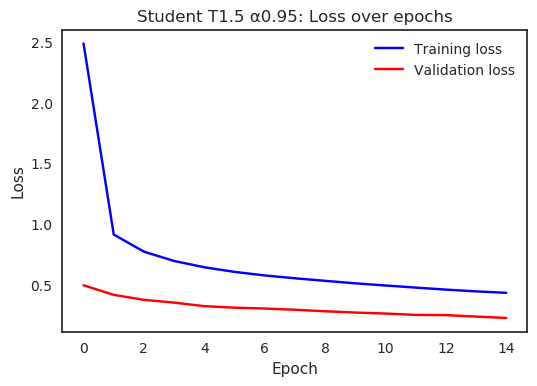

=======> Temperature: 2
00:29:33 --- Epoch: 0	Train loss: 4.9615	Valid loss: 0.6834	Train accuracy: 81.26	Valid accuracy: 82.26
00:29:57 --- Epoch: 1	Train loss: 1.8393	Valid loss: 0.5702	Train accuracy: 85.35	Valid accuracy: 86.08
00:30:21 --- Epoch: 2	Train loss: 1.6018	Valid loss: 0.5243	Train accuracy: 86.80	Valid accuracy: 87.49
00:30:45 --- Epoch: 3	Train loss: 1.4835	Valid loss: 0.4910	Train accuracy: 87.82	Valid accuracy: 88.29
00:31:08 --- Epoch: 4	Train loss: 1.3932	Valid loss: 0.4736	Train accuracy: 88.47	Valid accuracy: 88.86
00:31:32 --- Epoch: 5	Train loss: 1.3016	Valid loss: 0.4258	Train accuracy: 89.37	Valid accuracy: 89.57
00:31:55 --- Epoch: 6	Train loss: 1.2025	Valid loss: 0.3964	Train accuracy: 90.24	Valid accuracy: 90.32
00:32:21 --- Epoch: 7	Train loss: 1.1004	Valid loss: 0.3610	Train accuracy: 91.17	Valid accuracy: 91.22
00:32:47 --- Epoch: 8	Train loss: 1.0121	Valid loss: 0.3429	Train accuracy: 91.59	Valid accuracy: 91.85
00:33:12 --- Epoch: 9	Train loss: 0.9476

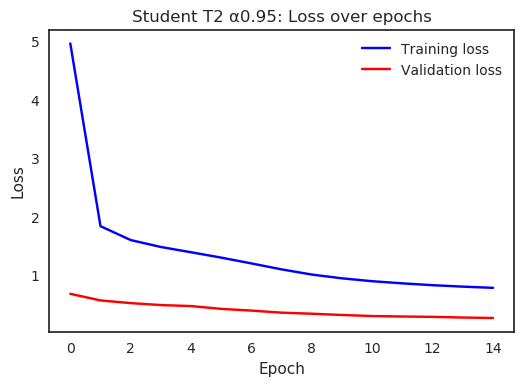

=======> Temperature: 3
00:35:35 --- Epoch: 0	Train loss: 8.7118	Valid loss: 0.6869	Train accuracy: 83.46	Valid accuracy: 84.58
00:35:58 --- Epoch: 1	Train loss: 3.3087	Valid loss: 0.5204	Train accuracy: 87.84	Valid accuracy: 88.68
00:36:23 --- Epoch: 2	Train loss: 2.7670	Valid loss: 0.4643	Train accuracy: 89.08	Valid accuracy: 89.84
00:36:46 --- Epoch: 3	Train loss: 2.4873	Valid loss: 0.4265	Train accuracy: 90.04	Valid accuracy: 90.64
00:37:11 --- Epoch: 4	Train loss: 2.3079	Valid loss: 0.3986	Train accuracy: 90.74	Valid accuracy: 91.08
00:37:35 --- Epoch: 5	Train loss: 2.1711	Valid loss: 0.3800	Train accuracy: 91.05	Valid accuracy: 91.42
00:37:59 --- Epoch: 6	Train loss: 2.0534	Valid loss: 0.3554	Train accuracy: 91.59	Valid accuracy: 92.16
00:38:23 --- Epoch: 7	Train loss: 1.9511	Valid loss: 0.3420	Train accuracy: 91.93	Valid accuracy: 92.42
00:38:46 --- Epoch: 8	Train loss: 1.8639	Valid loss: 0.3350	Train accuracy: 92.07	Valid accuracy: 92.58
00:39:10 --- Epoch: 9	Train loss: 1.7908

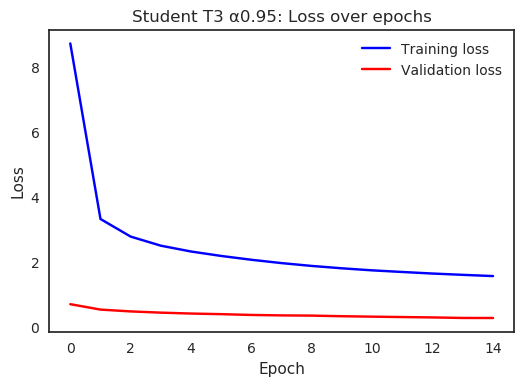

=======> Temperature: 4.5
00:41:36 --- Epoch: 0	Train loss: 15.6779	Valid loss: 0.9094	Train accuracy: 80.57	Valid accuracy: 81.96
00:41:59 --- Epoch: 1	Train loss: 7.5565	Valid loss: 0.7362	Train accuracy: 83.76	Valid accuracy: 84.58
00:42:23 --- Epoch: 2	Train loss: 6.6791	Valid loss: 0.6617	Train accuracy: 85.23	Valid accuracy: 86.25
00:42:50 --- Epoch: 3	Train loss: 6.1793	Valid loss: 0.6150	Train accuracy: 86.48	Valid accuracy: 87.21
00:43:14 --- Epoch: 4	Train loss: 5.7997	Valid loss: 0.5930	Train accuracy: 86.67	Valid accuracy: 87.48
00:43:38 --- Epoch: 5	Train loss: 5.4227	Valid loss: 0.5179	Train accuracy: 88.12	Valid accuracy: 88.99
00:44:03 --- Epoch: 6	Train loss: 5.0557	Valid loss: 0.4843	Train accuracy: 89.16	Valid accuracy: 89.91
00:44:27 --- Epoch: 7	Train loss: 4.7724	Valid loss: 0.4632	Train accuracy: 89.34	Valid accuracy: 89.91
00:44:51 --- Epoch: 8	Train loss: 4.5458	Valid loss: 0.4230	Train accuracy: 90.24	Valid accuracy: 90.45
00:45:16 --- Epoch: 9	Train loss: 4.3

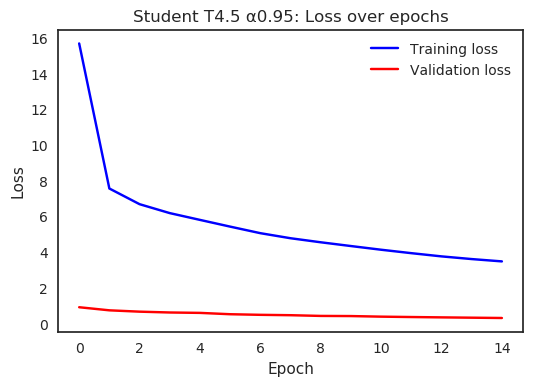

=======> Temperature: 6
00:47:41 --- Epoch: 0	Train loss: 21.1630	Valid loss: 0.8779	Train accuracy: 80.53	Valid accuracy: 81.50
00:48:05 --- Epoch: 1	Train loss: 10.4383	Valid loss: 0.8044	Train accuracy: 82.42	Valid accuracy: 83.10
00:48:28 --- Epoch: 2	Train loss: 9.5336	Valid loss: 0.7627	Train accuracy: 83.31	Valid accuracy: 84.12
00:48:52 --- Epoch: 3	Train loss: 9.1202	Valid loss: 0.7152	Train accuracy: 84.63	Valid accuracy: 85.33
00:49:16 --- Epoch: 4	Train loss: 8.8392	Valid loss: 0.7113	Train accuracy: 84.54	Valid accuracy: 85.35
00:49:39 --- Epoch: 5	Train loss: 8.6286	Valid loss: 0.7232	Train accuracy: 84.33	Valid accuracy: 84.91
00:50:04 --- Epoch: 6	Train loss: 8.4569	Valid loss: 0.6994	Train accuracy: 85.05	Valid accuracy: 85.77
00:50:27 --- Epoch: 7	Train loss: 8.3213	Valid loss: 0.6748	Train accuracy: 85.39	Valid accuracy: 86.22
00:50:51 --- Epoch: 8	Train loss: 8.2121	Valid loss: 0.6480	Train accuracy: 86.13	Valid accuracy: 86.92
00:51:16 --- Epoch: 9	Train loss: 8.12

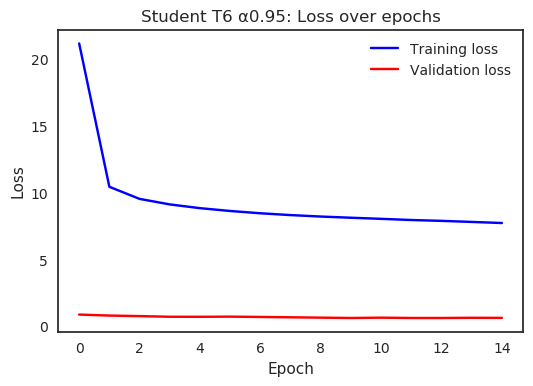

=======> Temperature: 8
00:53:49 --- Epoch: 0	Train loss: 25.7258	Valid loss: 1.0286	Train accuracy: 77.05	Valid accuracy: 77.92
00:54:14 --- Epoch: 1	Train loss: 12.9097	Valid loss: 0.8247	Train accuracy: 81.42	Valid accuracy: 81.73
00:54:38 --- Epoch: 2	Train loss: 11.2132	Valid loss: 0.7540	Train accuracy: 83.20	Valid accuracy: 83.41
00:55:01 --- Epoch: 3	Train loss: 10.3079	Valid loss: 0.6751	Train accuracy: 84.48	Valid accuracy: 85.00
00:55:25 --- Epoch: 4	Train loss: 9.5499	Valid loss: 0.5865	Train accuracy: 86.04	Valid accuracy: 86.73
00:55:48 --- Epoch: 5	Train loss: 8.9499	Valid loss: 0.5078	Train accuracy: 87.68	Valid accuracy: 88.39
00:56:13 --- Epoch: 6	Train loss: 8.4807	Valid loss: 0.4492	Train accuracy: 88.81	Valid accuracy: 89.65
00:56:38 --- Epoch: 7	Train loss: 8.1147	Valid loss: 0.4726	Train accuracy: 88.20	Valid accuracy: 88.95
00:57:03 --- Epoch: 8	Train loss: 7.8187	Valid loss: 0.4159	Train accuracy: 89.26	Valid accuracy: 89.90
00:57:26 --- Epoch: 9	Train loss: 7.

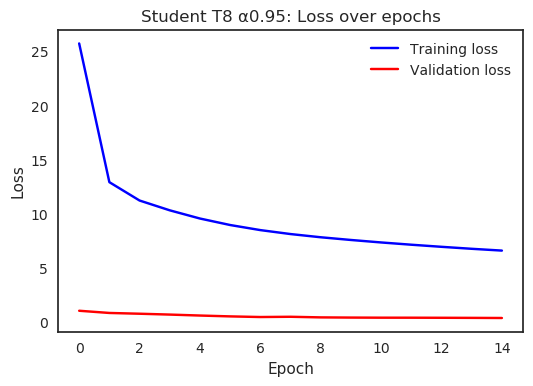

=======> Temperature: 10
00:59:49 --- Epoch: 0	Train loss: 28.7177	Valid loss: 0.9495	Train accuracy: 79.03	Valid accuracy: 79.58
01:00:13 --- Epoch: 1	Train loss: 12.8724	Valid loss: 0.7799	Train accuracy: 82.96	Valid accuracy: 83.78
01:00:36 --- Epoch: 2	Train loss: 11.4294	Valid loss: 0.6712	Train accuracy: 84.86	Valid accuracy: 85.86
01:00:59 --- Epoch: 3	Train loss: 10.4516	Valid loss: 0.5860	Train accuracy: 86.20	Valid accuracy: 86.89
01:01:22 --- Epoch: 4	Train loss: 9.6325	Valid loss: 0.5363	Train accuracy: 87.29	Valid accuracy: 87.82
01:01:47 --- Epoch: 5	Train loss: 8.9158	Valid loss: 0.4760	Train accuracy: 88.24	Valid accuracy: 89.11
01:02:13 --- Epoch: 6	Train loss: 8.3184	Valid loss: 0.4160	Train accuracy: 89.18	Valid accuracy: 90.09
01:02:38 --- Epoch: 7	Train loss: 7.8479	Valid loss: 0.4160	Train accuracy: 89.23	Valid accuracy: 89.94
01:03:04 --- Epoch: 8	Train loss: 7.4684	Valid loss: 0.4146	Train accuracy: 89.39	Valid accuracy: 89.86
01:03:30 --- Epoch: 9	Train loss: 7

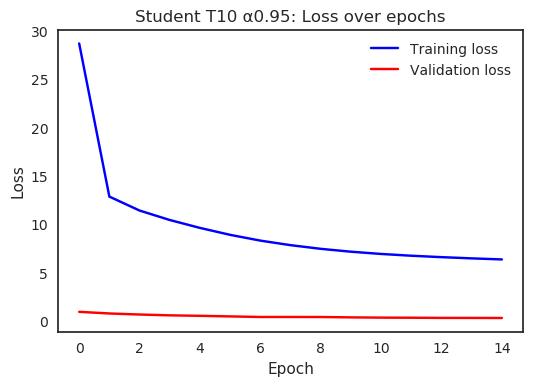

=======> Temperature: 20
01:05:52 --- Epoch: 0	Train loss: 31.6885	Valid loss: 1.3971	Train accuracy: 69.98	Valid accuracy: 69.96
01:06:15 --- Epoch: 1	Train loss: 16.3380	Valid loss: 1.1315	Train accuracy: 75.55	Valid accuracy: 76.02
01:06:39 --- Epoch: 2	Train loss: 14.1847	Valid loss: 0.9694	Train accuracy: 78.15	Valid accuracy: 78.71
01:07:02 --- Epoch: 3	Train loss: 13.1680	Valid loss: 0.9003	Train accuracy: 79.45	Valid accuracy: 79.95
01:07:25 --- Epoch: 4	Train loss: 11.7780	Valid loss: 0.7423	Train accuracy: 82.13	Valid accuracy: 82.73
01:07:49 --- Epoch: 5	Train loss: 10.4491	Valid loss: 0.6254	Train accuracy: 84.31	Valid accuracy: 84.77
01:08:12 --- Epoch: 6	Train loss: 9.5530	Valid loss: 0.5441	Train accuracy: 85.72	Valid accuracy: 86.24
01:08:36 --- Epoch: 7	Train loss: 8.9709	Valid loss: 0.5302	Train accuracy: 86.08	Valid accuracy: 86.40
01:08:59 --- Epoch: 8	Train loss: 8.5604	Valid loss: 0.4710	Train accuracy: 87.35	Valid accuracy: 87.80
01:09:22 --- Epoch: 9	Train loss:

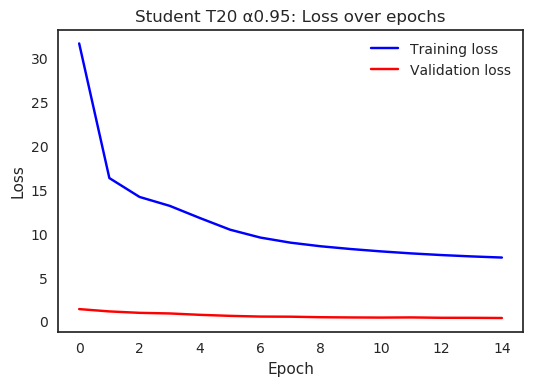

In [9]:
class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, temperature, alpha):
        super(SoftCrossEntropyLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
    
    def forward(self, student_pred, label, teacher_pred):
        return nn.KLDivLoss(reduction="batchmean")(F.log_softmax(student_pred/self.T,dim=1), F.softmax(teacher_pred[0]/self.T, dim=1)) * self.alpha * self.T * self.T + \
    F.cross_entropy(student_pred, label) * (1-self.alpha)


# Train
temperatures = [1, 1.5, 2, 3, 4.5, 6, 8, 10, 20]
LEARNING_RATE = 0.001
N_EPOCHS = 15
ALPHA = 0.95

for t in temperatures:
    print(f"=======> Temperature: {t}")
    model_s = StudentNet(N_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

    valid_criterion = nn.CrossEntropyLoss()
    train_criterion = SoftCrossEntropyLoss(t, ALPHA)
    prefix = f"student_T{t}_α{ALPHA}"
    dir_path = f"./student_models/{prefix}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)
    
    params = {"dir": dir_path,
          "prefix": prefix, 
          "title": f"Student T{t} α{ALPHA}"
         }
    
    model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                        N_EPOCHS, DEVICE, params, teacher_model=model_teacher)
    torch.save(model_s.state_dict(), f"{dir_path}/{prefix}_parameters.pt")  

In [10]:
!pip install pthflops
!pip install torchsummary

In [11]:
from pthflops import count_ops
from torchsummary import summary

student_model = StudentNet(N_CLASSES).to(DEVICE)
 
summary(student_model, (1, 28, 28))
count_ops(student_model.model, torch.rand(1,1,28,28).to(DEVICE))

Unable to import torch.fx, you pytorch version may be too old.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              26
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
            Conv2d-4              [-1, 2, 9, 9]              52
              ReLU-5              [-1, 2, 9, 9]               0
         AvgPool2d-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 408
Trainable params: 408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------

/opt/conda/lib/python3.6/site-packages/pthflops/__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)


(24426,
 [['Sequential/Conv2d[0]/onnx::Conv', 17576],
  ['Sequential/ReLU[1]/onnx::Relu', 1352],
  ['Sequential/AvgPool2d[2]/onnx::AveragePool', 676],
  ['Sequential/Conv2d[3]/onnx::Conv', 4050],
  ['Sequential/ReLU[4]/onnx::Relu', 324],
  ['Sequential/AvgPool2d[5]/onnx::AveragePool', 128],
  ['Sequential/Linear[7]/onnx::Gemm', 320]])